In [1]:
%load_ext autoreload
%autoreload 2
import pandas
import os
from plotnine import *
import plotnine
plotnine.options.figure_size = (12, 8)
import twitter as tw

In [2]:
users = {
    'EricPiolle': 'Grenoble en Commun',
    'Grenoble_Commun': 'Grenoble en Commun',
    'EmilieCChalas': 'Un Nouveau Regard sur Grenoble',
    'Chalas2020': 'Un Nouveau Regard sur Grenoble',
    'CarignonAlain': 'Grenoble le Changement',
    'onoblecourt': 'Grenoble Nouvel Air',
    'GrenobleNvAir': 'Grenoble Nouvel Air',
}
colors = {
    'Grenoble en Commun': '#00c000',
    'Un Nouveau Regard sur Grenoble': '#ffb400',
    'Grenoble le Changement': '#0066CC',
    'Grenoble Nouvel Air': '#ff8080',    
}

In [3]:
filename = 'data_lists.csv'
if not os.path.isfile(filename):
    df = pandas.concat([tw.get_data(user, n=200, tag=tag) for user, tag in users.items()])
    df.to_csv(filename, index=False)
else:
    df = pandas.read_csv(filename)
    df['date'] = pandas.to_datetime(df['date'])
df = df[df['date'] >= pandas.to_datetime('2019-09-01')]
print(len(df), len(df.columns))

847 10


In [4]:
df.groupby('name')[['date']].agg(['min', 'max', 'count'])

date                          
                                               min                 max count
name                                                                        
Grenoble Nouvel Air            2019-10-14 08:57:38 2020-02-19 15:40:49   273
Grenoble en Commun             2019-10-01 14:48:39 2020-02-19 16:00:01   303
Un Nouveau Regard sur Grenoble 2019-10-26 12:09:19 2020-02-19 11:59:18   271

In [5]:
df.sample(n=10)

,name,login,likes,retweets,text,date,in_reply,source,coordinates,geo
344,Un Nouveau Regard sur Grenoble,Chalas2020,7,10,⏰ Vendredi 14 février 2020 à 18h30 !\n\nPour r...,2020-02-13 14:00:27,NaN,Twitter for iPhone,NaN,NaN
635,Grenoble Nouvel Air,GrenobleNvAir,10,5,"[🗣🎤📢 RÉUNION PUBLIQUE] JP Vergus ""On a oublié ...",2020-02-10 18:07:41,NaN,Twitter Web App,NaN,NaN
509,Un Nouveau Regard sur Grenoble,Chalas2020,4,4,🔶 RENDEZ-VOUS EN BAS DE CHEZ VOUS !\n\n➡️ Nous...,2019-12-17 10:19:23,NaN,Twitter for iPhone,NaN,NaN
454,Un Nouveau Regard sur Grenoble,Chalas2020,8,6,🔶 TRACTAGE ! \n\n➡️ Notre collectif était prés...,2020-01-22 18:10:52,NaN,Twitter for iPhone,NaN,NaN
484,Un Nouveau Regard sur Grenoble,Chalas2020,10,4,🔶 TOC TOC TOUR ! \n\n➡️ Notre collectif citoye...,2020-01-09 19:29:35,NaN,Twitter for iPhone,NaN,NaN
393,Un Nouveau Regard sur Grenoble,Chalas2020,18,12,La situation de pollution atmosphérique et le ...,2020-02-03 20:46:56,NaN,Twitter Web App,NaN,NaN
507,Un Nouveau Regard sur Grenoble,Chalas2020,4,3,Nous allons développer les murs et les toits v...,2019-12-18 16:02:32,NaN,Loomly,NaN,NaN
219,Grenoble en Commun,Grenoble_Commun,30,10,"🔴Après la @FranceInsoumise, @GEcologie, @Ensem...",2019-11-22 13:59:46,NaN,Twitter Web App,NaN,NaN
834,Grenoble Nouvel Air,GrenobleNvAir,5,3,"[✍️APPEL CITOYEN] Vous aussi, comme déjà plusi...",2019-12-02 14:10:10,NaN,Twitter Web App,NaN,NaN
101,Grenoble en Commun,Grenoble_Commun,27,21,Garantir les sécurité sociales : expérimenter ...,2020-01-23 17:04:37,NaN,TweetDeck,NaN,NaN


/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 16 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/figure.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


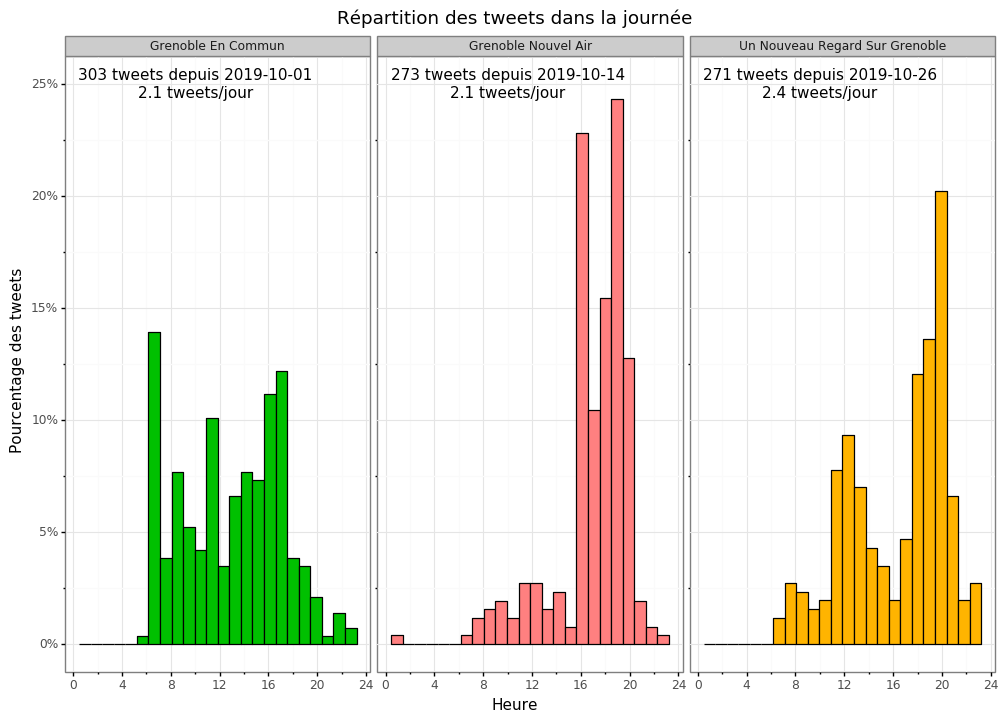

<ggplot: (8773881887380)>

In [6]:
from mizani.formatters import percent_format

def format_text(row):
    return f'{row["count"]} tweets depuis {row["min"]}\n{row["intensity"]:.1f} tweets/jour'

def format_name(row):  # some candidates write their names in all-caps...
    names = row['name'].lower().split()
    names = [f'{n[0].upper()}{n[1:]}' for n in names]
    return ' '.join(names)

df['tag'] = df.apply(lambda row: users[row['login']], axis=1)
df['name'] = df.apply(format_name, axis=1)

tmp = df.groupby('name')[['date']].agg(['min', 'max', 'count']).reset_index(col_level=1)
tmp.columns = tmp.columns.droplevel()
tmp['intensity'] = tmp['count'] / (tmp['max'] - tmp['min']).dt.days
tmp['min'] = tmp['min'].dt.date
tmp['max'] = tmp['max'].dt.date
tmp['text'] = tmp.apply(format_text, axis=1)
tmp

df['time'] = pandas.to_timedelta(df['date'].dt.time.astype(str)).dt.total_seconds() / 3600  # some dirty hack
plot = ggplot(df) +\
    geom_histogram(aes(x='time', fill='tag', y='..density..'), color='black', bins=24) +\
    theme_bw() +\
    scale_fill_manual(colors) +\
    xlab('Heure') +\
    ylab('Pourcentage des tweets') +\
    labs(fill='Mouvement') +\
    facet_wrap('name') +\
    theme(legend_position='none') +\
    scale_x_continuous(breaks=range(0, 25, 4)) +\
    scale_y_continuous(labels = percent_format()) +\
    geom_text(tmp, aes(label='text'), x=10, y=0.25) + expand_limits(y=0.25) +\
    ggtitle('Répartition des tweets dans la journée')

plot.save('/tmp/figure.png', width=16, height=10)

plot

In [7]:
df.groupby('name')[['date']].agg(['min', 'count'])

date      
                                               min count
name                                                    
Grenoble En Commun             2019-10-01 14:48:39   303
Grenoble Nouvel Air            2019-10-14 08:57:38   273
Un Nouveau Regard Sur Grenoble 2019-10-26 12:09:19   271

In [8]:
df.groupby(['name', 'source'])[['date']].count()

date
name                           source                   
Grenoble En Commun             TweetDeck             124
                               Twitter Web App        72
                               Twitter for Android    28
                               Twitter for Mac        25
                               Twitter for iPhone     54
Grenoble Nouvel Air            Twitter Web App       215
                               Twitter Web Client      1
                               Twitter for iPhone     57
Un Nouveau Regard Sur Grenoble Loomly                  3
                               Twitter Web App        45
                               Twitter for Android     1
                               Twitter for iPad        2
                               Twitter for iPhone    220

In [9]:
tmp = tw.get_mentions(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name                           mention               
Grenoble Nouvel Air            @onoblecourt       133
Un Nouveau Regard Sur Grenoble @EmilieCChalas      80
Grenoble En Commun             @EricPiolle         45
Grenoble Nouvel Air            @ADTCgrenoble       21
                               @najatvb            16
Un Nouveau Regard Sur Grenoble @Chalas2020         11
Grenoble En Commun             @NDIsere             8
Grenoble Nouvel Air            @Mercedes_Erra       7
Grenoble En Commun             @GEcologie           7
                               @EnsembleGre38       7
                               @FranceInsoumise     6
                               @cmoreldarleux       5
Un Nouveau Regard Sur Grenoble @teleGrenoble        5
Grenoble En Commun             @GenerationsMvt      4
Un Nouveau Regard Sur Grenoble @MarleneSchiappa     3
Grenoble Nouvel Air            @rom1gre             3
Grenoble En Commun             @placepublique_      3
Grenoble Nouvel Air            @f3Alpes             3
                               @ONoblecourt         3
Grenoble En Commun             @PartiAnimaliste     3

In [10]:
tmp = tw.get_hashtags(df)
tmp.groupby(['name', 'mention'])[['date']].count().sort_values(by='date', ascending=False).head(n=20)

date
name                           mention                          
Un Nouveau Regard Sur Grenoble #Grenoble                     197
Grenoble Nouvel Air            #GrenobleNouvelAir            175
Grenoble En Commun             #GrenobleEnCommun             113
Un Nouveau Regard Sur Grenoble #UnNouveauRegardSurGrenoble    89
                               #Chalas2020                    79
Grenoble Nouvel Air            #Municipales2020               70
Grenoble En Commun             #Grenoble                      68
Grenoble Nouvel Air            #Grenoble                      62
                               #Noblecourt                    33
                               #Lalternative                  30
Grenoble En Commun             #LaFabrique                    20
Grenoble Nouvel Air            #LeProjet                      20
Un Nouveau Regard Sur Grenoble #Municipales2020               18
Grenoble En Commun             #IciCestGrenoble               16
Grenoble Nouvel Air            #Meeting                       13
Grenoble En Commun             #AperoPhilo                    12
Grenoble Nouvel Air            #Alternative                   10
Un Nouveau Regard Sur Grenoble #2020                           7
Grenoble En Commun             #grevedu5decembre               7
                               #Municipales2020                7

In [11]:
tw.count_patterns(df, ['climat', 'dette', 'corruption', 'corrompu', 'retraite', 'arbre'])

,name,login,tweet,pattern
0,Grenoble En Commun,Grenoble_Commun,54,climat
2,Un Nouveau Regard Sur Grenoble,Chalas2020,3,climat
1,Un Nouveau Regard Sur Grenoble,Chalas2020,2,arbre
1,Grenoble Nouvel Air,GrenobleNvAir,2,climat
0,Grenoble En Commun,Grenoble_Commun,2,arbre
0,Un Nouveau Regard Sur Grenoble,Chalas2020,1,dette
0,Un Nouveau Regard Sur Grenoble,Chalas2020,1,retraite
1,Grenoble Nouvel Air,GrenobleNvAir,1,corrompu
0,Grenoble En Commun,Grenoble_Commun,1,corrompu


In [12]:
tw.count_patterns(df, ['piolle', 'carignon', 'chalas', 'noblecourt'])

,name,login,tweet,pattern
1,Un Nouveau Regard Sur Grenoble,Chalas2020,136,chalas
0,Grenoble Nouvel Air,GrenobleNvAir,131,noblecourt
0,Grenoble En Commun,Grenoble_Commun,50,piolle
2,Un Nouveau Regard Sur Grenoble,Chalas2020,3,carignon
2,Un Nouveau Regard Sur Grenoble,Chalas2020,2,piolle
0,Grenoble En Commun,Grenoble_Commun,2,carignon
1,Grenoble Nouvel Air,GrenobleNvAir,1,piolle
1,Grenoble Nouvel Air,GrenobleNvAir,1,carignon
0,Grenoble En Commun,Grenoble_Commun,1,chalas


/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 16 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/tom/.cache/pypoetry/virtualenvs/twitter-data-NGoNO7rx-py3.7/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /tmp/figure.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


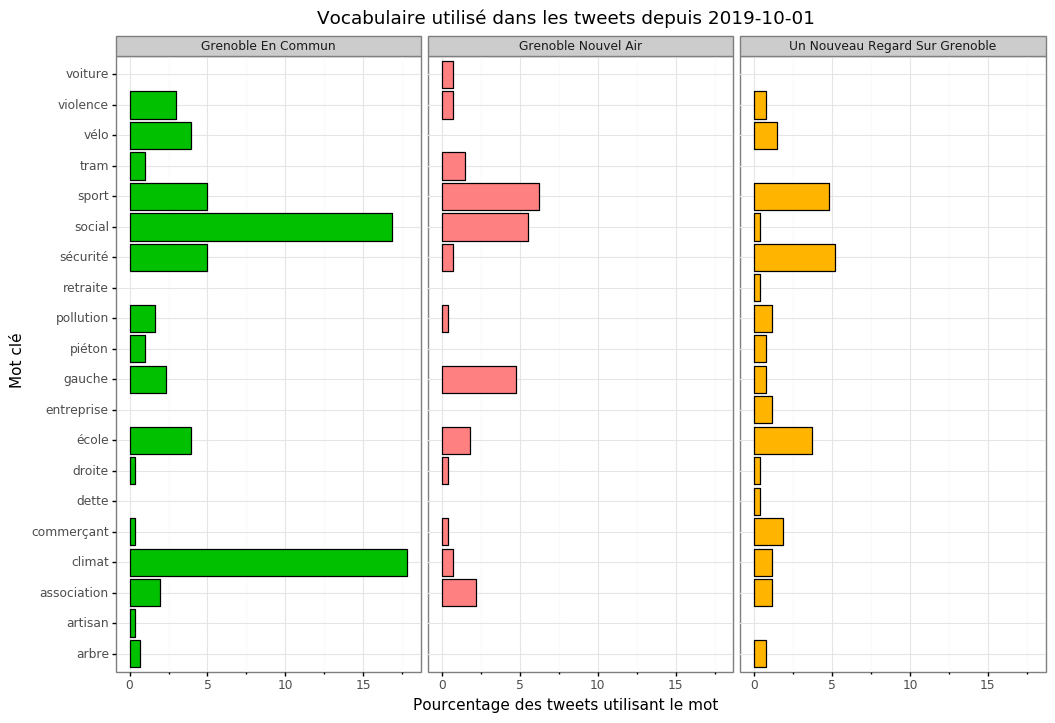

<ggplot: (8773879121237)>

In [13]:
keywords = [
    'arbre',
    'artisan',
    'association',
    'climat',
    'commerçant',
    'dette',
    'droite',
    'école',
    'entreprise',
    'gauche',
    'piéton',
    'pollution',
    'retraite',
    'sécurité',
    'social',
    'sport',
    'tram',
    'vélo',
    'violence',
    'voiture',
]

def get_keywords(df, keywords):
    tmp = tw.count_patterns(df, keywords)
    tmp['tag'] = tmp.apply(lambda row: users[row['login']], axis=1)
    nb_tweets = df.groupby('login')[['name']].count().reset_index()
    nb_tweets.columns = ['login', 'count']
    tmp = tmp.set_index('login').join(nb_tweets.set_index('login'))
    tmp['percent'] = tmp['tweet'] / tmp['count'] * 100
    diff = set(keywords) - set(tmp.pattern.unique())
    if len(diff) > 0:
        raise ValueError(f'Some keywords were missing: {diff}')
    return tmp

def plot_keywords(df, keywords):
    tmp = get_keywords(df, keywords)
    min_date = df['date'].min().date()
    plot = ggplot(tmp) +\
        geom_bar(aes(x='pattern', y='percent', fill='tag'), stat='identity', color='black', position='dodge') +\
        theme_bw() +\
        scale_fill_manual(colors) +\
        xlab('Mot clé') +\
        ylab('Pourcentage des tweets utilisant le mot') +\
        labs(fill='Mouvement') +\
        facet_wrap('name') +\
        theme(legend_position='none') +\
        ggtitle(f'Vocabulaire utilisé dans les tweets depuis {min_date}') +\
        scale_x_discrete(limits=keywords) +\
        coord_flip()

    plot.save('/tmp/figure.png', width=16, height=10)

    return plot

plot_keywords(df, keywords)